In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import logging
from numpy import convolve
from matplotlib.gridspec import GridSpec
import bilby
import time as timer
from scipy import signal
global fch1,bwchan,nchan,ftop,fcentre
from astropy import units as u
MIN_FLOAT = sys.float_info[3]
fch1=1104 ## Fch1 1104 MHz
bwchan=1## bwchan 1 MHz
nchan=336## nchan=336
ftop=fch1/1000 ##GHz
fcentre=(fch1+bwchan*nchan/2)/1000 ##GHz
print("fch1,bwchan(MHz),nchan,ftop,fcentre")
print(fch1,bwchan,nchan,ftop,fcentre,fch1+bwchan*336)

17:39 bilby INFO    : Running bilby version: 0.5.2:
17:39 bilby WARNING : You do not have gwpy installed currently. You will  not be able to use some of the prebuilt functions.
17:39 bilby WARNING : You do not have lalsuite installed currently. You will not be able to use some of the prebuilt functions.
17:39 bilby WARNING : You do not have gwpy installed currently. You will  not be able to use some of the prebuilt functions.
17:39 bilby WARNING : You do not have lalsuite installed currently. You will not be able to use some of the prebuilt functions.
17:39 bilby WARNING : You do not have gwpy installed currently. You will  not be able to use some of the prebuilt functions.
17:39 bilby WARNING : You do not have lalsuite installed currently. You will not be able to use some of the prebuilt functions.
17:39 bilby WARNING : You do not have lalsuite installed currently. You will not be able to use some of the prebuilt functions.


fch1,bwchan(MHz),nchan,ftop,fcentre
1104 1 336 1.104 1.272 1440


In [2]:
filex='t_x_total_dm589.265_tr.npy'
filey='t_y_polcal_total_dm589.265_tr.npy'
basetsamp=1/336e6*u.second
xpol=np.load(filex)
ypol=np.load(filey)

In [3]:
realx=np.abs(xpol)
realy=np.abs(ypol)
stokesI=(realx**2+realy**2)

5504856.0 (169, 16384) (5505024,) [0.5]
spectrogram time axis length (16384,)
binned stokesI axis (16384,)
true time resolution in spectrogram 1.0 us
(168, 4096) 4.0 us


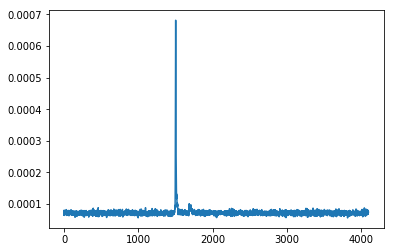

1.9881656804733727 4.0


In [52]:
f, t, Sxx=signal.spectrogram(stokesI,fs=1,nperseg=336,noverlap=0)
tbin=4
print(t[-1],Sxx.shape,stokesI.shape,(stokesI.shape-t[-1])/336)
print('spectrogram time axis length',Sxx.sum(axis=0).shape)
print('binned stokesI axis',stokesI.reshape(-1,336).sum(1).shape)
#print(stokesI.shape[0]/Sxx.sum(axis=0).shape[0])
newtsamp=stokesI.shape[0]/Sxx.sum(axis=0).shape[0]*basetsamp.to(u.us)
print('true time resolution in spectrogram',newtsamp)
data=Sxx[:168,:].reshape(168,int(16384/tbin),tbin).sum(2)
tsamp=newtsamp*tbin
print(data.shape,tsamp)
np.save(arr=data,file='frb_hightime')
tsamp=tsamp.value
plt.plot(data.sum(0))
plt.show()
nchan=169
bwchan=336/nchan
print(bwchan,tsamp)

# Functions for FRB with scattering as follows

In [5]:
### gaussian
def gaus_func(sigi,t0,t,ti):
    sit=1/np.sqrt(np.pi*2*(sigi**2))*np.exp(-(t-t0-ti)**2/sigi**2) ### model 0 in ravi 2018
    return sit

### adjust dm
def tidm(dmerr,vi):
    beta=2
    #ftop=1464/1000 ## MHz--->GHz
    #fbot=1128/1000 ## MHz--->GHz
    ### ftop GHz
    ### 4.15 ms
    ti=4.15*dmerr*(ftop**(-beta)-vi**(-beta)) ### ms
    return ti

### scattering
def scat(t,t0,tau1,alpha,v):
    ###tau=tau1/1000 ## ms
    flux=np.zeros(len(t)) + MIN_FLOAT
    flux[t>=t0]=np.exp(-(t[t>=t0]-t0)/(tau1*(v/fcentre)**(-alpha)))
    return flux

### dm smearing
def delta_t(dm,v):
    ### calculate dm smearing
    beta=2
    dt=1.622e-3*dm*(v**(-beta-1)) ### v is GHz / dt is ms
    return dt

In [55]:
def scat_pulse(t,t0,tau1,dm,dmerr,sigma,alpha,a,vi):
    ### vi is GHz
    dm_0=dm+dmerr 
    ti=tidm(dmerr,vi)*1000##ms--->us
    #smear=delta_t(dm_0,vi) ##ms
    smear=0
    width=np.sqrt(sigma**2+smear**2)
    gt0=np.mean(t)
    pulse=gaus_func(width,gt0,t,ti) ## create pulse
    scat_corr=scat(t,t0,tau1,alpha,vi) ## create scatter kernel
    flux=convolve(scat_corr,pulse,'same')
    flux/=np.max(flux) ### normalise
    return a*flux
#### get a frequency splitter
def freq_splitter_idx(n,skip,end):
    dw=(end-skip)/n
    print(dw,bwchan)
    vi=np.arange(n)*dw*bwchan+0.5*dw*bwchan
    base=fch1+skip*bwchan
    vi=base+vi
    chan_idx=np.arange(n)*dw+skip
    chan_idx=np.append(chan_idx,end)
    chan_idx=chan_idx.astype(np.int)
    return vi,chan_idx
#### load data with this

def dataloader(name,chan_idx,head=10,tail=40):
    data=np.load(name)
    data=(data.T-np.median(data,1)).T
    #stokesI_rms=np.loadtxt("FRB_HTR_xpol-imageplane-rms.stokesI.txt")[1:].T
    #print("bandwidth GHz/MHz",bwchan,bwchan*1000)
    #print(data.shape)
    #print(ftop,vi,chan_idx)
    time=np.arange(data.shape[1])*tsamp
    #ytot=data.std()
    #print(ytot)
    sigma=[]
    ydata=[]
    for i in range(len(chan_idx)-1):
        ytot=data[chan_idx[i]:chan_idx[i+1]].mean(axis=0).std()
        ydata.append(data[chan_idx[i]:chan_idx[i+1]].mean(axis=0)/ytot)
        sigma.append(ytot)
    ydata=np.array(ydata)
    print (ydata.shape)
    x0=np.argmax(data.mean(axis=0)/ytot)
    print(time[x0],'peak data')
    ydata=ydata[:,x0-head:x0+tail]
    time=np.arange(ydata.shape[1])*tsamp
    return time,ydata,sigma


21.0 1.9881656804733727
[1124.87573964 1166.62721893 1208.37869822 1250.13017751 1291.8816568
 1333.63313609 1375.38461538 1417.13609467] [  0  21  42  63  84 105 126 147 168]
(8, 4096)
6008.0 peak data


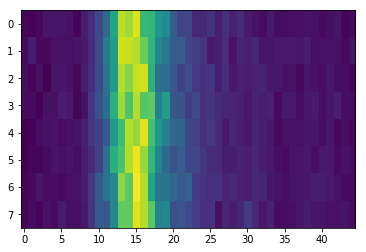

[  0.   4.   8.  12.  16.  20.  24.  28.  32.  36.  40.  44.  48.  52.
  56.  60.  64.  68.  72.  76.  80.  84.  88.  92.  96. 100. 104. 108.
 112. 116. 120. 124. 128. 132. 136. 140. 144. 148. 152. 156. 160. 164.
 168. 172. 176.] 4.0


In [81]:
vi,chan_idx=freq_splitter_idx(n=8,skip=0,end=168)
print(vi,chan_idx)
global freq,dm
freq=np.array(vi)/1000 ## GHz
dm=589.265 ###dm value


time,ydata,err=dataloader("frb_hightime.npy",chan_idx,head=15,tail=30)

plt.imshow(ydata,aspect='auto')
plt.show()
print(time,tsamp)

In [82]:
def multipulse(t,t0,tau1,dmerr,sigi,alpha,a1,a2,a3,a4,a5,a6,a7,a8):
    amp_list=np.array([a1,a2,a3,a4,a5,a6,a7,a8])
    model=[]
    sigma=sigi
    for vi,am in zip(freq,amp_list):
        #print (vi,am)
        model.append(scat_pulse(t,t0,tau1,dm,dmerr,sigma,alpha,am,vi))
    return np.array(model)


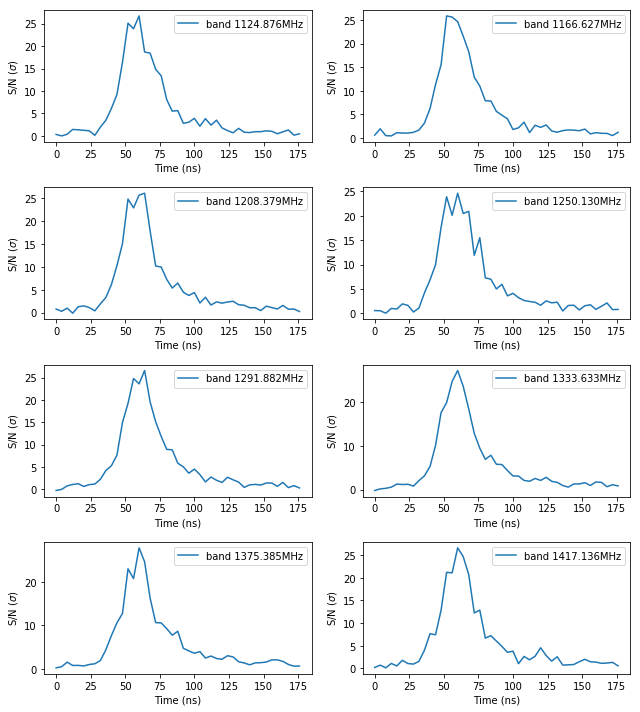

In [83]:
o='frb_htr_test'
plt.figure(figsize=(9,10))
for i in range(8):
    plt.subplot(4,2,i+1)
    plt.plot(time,ydata[i],label="band "+"{0:.3f}".format(vi[i])+"MHz")
    #plt.plot(time,np.ones(len(time))*0.02,linestyle="--",label="rms from dynesty")
    plt.legend()
    plt.ylabel('S/N ($\sigma$)')
    plt.xlabel('Time (ns)')
plt.tight_layout()

plt.savefig(o+"band_data.png",dpi=300)
plt.show()
plt.close()

## Test multipulse model

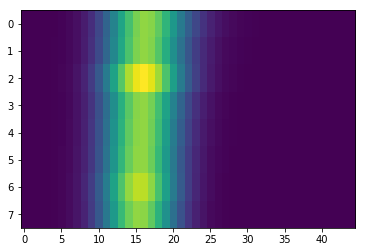

In [84]:
plt.imshow(multipulse(time,t0=60,tau1=5,dmerr=0,sigi=20,alpha=4,a1=25,a2=25,a3=30,a4=25,a5=25
                      ,a6=25,a7=27,a8=25),aspect='auto')
#plt.figure()
#plt.plot(scat_pulse(t=time,t0=,tau1,dm,dmerr,sigma,alpha,a,vi))
plt.show()

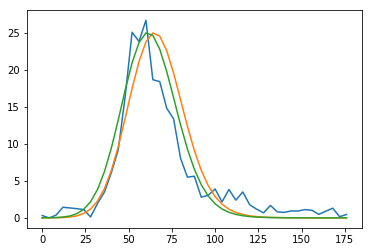

In [85]:
plt.plot(time,ydata[0])
plt.plot(time,scat_pulse(time,t0=60,tau1=5,dm=0,dmerr=0,sigma=20,alpha=4,a=25,vi=1.12487573964))
plt.plot(time,scat_pulse(time,t0=60,tau1=5,dm=0,dmerr=-0.03,sigma=20,alpha=4,a=25,vi=1.12487573964))
plt.show()

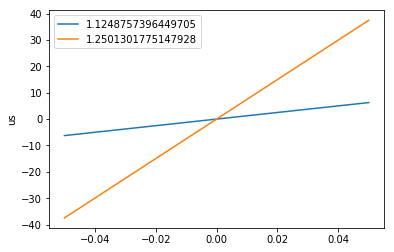

In [62]:
testdm=np.linspace(-0.05,0.05,100)
plt.plot(testdm,tidm(testdm,freq[0])*1000,label=freq[0])
plt.plot(testdm,tidm(testdm,freq[3])*1000,label=freq[3])
plt.legend()
plt.ylabel("us")
plt.show()

In [63]:
amin=2
amax=50
taumax=50 ### us
simpoints=500

global priors1
print(10*tsamp,20*tsamp)
priors1 = bilby.core.prior.PriorDict()
priors1["t0"]=bilby.core.prior.Uniform(name='t0', minimum=10*tsamp,maximum=20*tsamp) ###
priors1["tau1"]=bilby.core.prior.LogUniform(name='$\\tau$', minimum=1, maximum=taumax)
priors1["a1"]=bilby.core.prior.Uniform(name='a1', minimum=amin, maximum=amax)
priors1["a2"]=bilby.core.prior.Uniform(name='a2', minimum=amin, maximum=amax)
priors1["a3"]=bilby.core.prior.Uniform(name='a3', minimum=amin, maximum=amax)
priors1["a4"]=bilby.core.prior.Uniform(name='a4', minimum=amin, maximum=amax)
priors1["a5"]=bilby.core.prior.Uniform(name='a5', minimum=amin, maximum=amax)
priors1["a6"]=bilby.core.prior.Uniform(name='a6', minimum=amin, maximum=amax)
priors1["a7"]=bilby.core.prior.Uniform(name='a7', minimum=amin, maximum=amax)
priors1["a8"]=bilby.core.prior.Uniform(name='a8', minimum=amin, maximum=amax)
priors1["dmerr"]=bilby.core.prior.Uniform(name='dmerr', minimum=-0.05,maximum=0.05)
priors1["sigi"]=bilby.core.prior.Uniform(name='$\\sigma$', minimum=0.05, maximum=50)
priors1["alpha"]=bilby.core.prior.Uniform(name='alpha',minimum=1,maximum=10.0)
priors1["sigma"]=bilby.core.prior.Uniform(name='error',minimum=0.001,maximum=5)

40.0 80.0


In [64]:
likelihood = bilby.core.likelihood.GaussianLikelihood(x=time, y=ydata,func=multipulse, sigma=None)

In [65]:
result = bilby.sampler.run_sampler(likelihood=likelihood, priors=priors1,sampler='dynesty'
                                       ,npoints=simpoints,clean=True,dlogz=0.1,outdir='outdir',label=o)

22:18 bilby INFO    : Running for label 'frb_htr_test', output will be saved to 'outdir'
22:18 bilby INFO    : Search parameters:
22:18 bilby INFO    :   t0 = Uniform(minimum=40.0, maximum=80.0, name='t0', latex_label='t0', unit=None, boundary=None)
22:18 bilby INFO    :   tau1 = LogUniform(minimum=1, maximum=50, name='$\\tau$', latex_label='$\\tau$', unit=None, boundary=None)
22:18 bilby INFO    :   a1 = Uniform(minimum=2, maximum=50, name='a1', latex_label='a1', unit=None, boundary=None)
22:18 bilby INFO    :   a2 = Uniform(minimum=2, maximum=50, name='a2', latex_label='a2', unit=None, boundary=None)
22:18 bilby INFO    :   a3 = Uniform(minimum=2, maximum=50, name='a3', latex_label='a3', unit=None, boundary=None)
22:18 bilby INFO    :   a4 = Uniform(minimum=2, maximum=50, name='a4', latex_label='a4', unit=None, boundary=None)
22:18 bilby INFO    :   a5 = Uniform(minimum=2, maximum=50, name='a5', latex_label='a5', unit=None, boundary=None)
22:18 bilby INFO    :   a6 = Uniform(minimum=

 1660| logz=-1437.373 +/-  0.121 | dlogz: 396.609 >  0.100

/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


 1797| logz=-1386.778 +/-  0.128 | dlogz: 392.780 >  0.100

/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


 1815| logz=-1380.702 +/-  0.125 | dlogz: 386.497 >  0.100

/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


 1859| logz=-1360.788 +/-  0.130 | dlogz: 366.773 >  0.100

/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


 1872| logz=-1356.423 +/-  0.125 | dlogz: 362.109 >  0.100

/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


 1901| logz=-1347.561 +/-  0.128 | dlogz: 353.254 >  0.100

/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


 1912| logz=-1343.360 +/-  0.126 | dlogz: 348.921 >  0.100

/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


 1918| logz=-1342.051 +/-  0.123 | dlogz: 347.522 >  0.100

/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


 1936| logz=-1338.446 +/-  0.122 | dlogz: 343.908 >  0.100

/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


 1938| logz=-1337.914 +/-  0.124 | dlogz: 343.452 >  0.100

/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


 1963| logz=-1330.356 +/-  0.128 | dlogz: 377.504 >  0.100

/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


 1999| logz=-1317.950 +/-  0.125 | dlogz: 364.801 >  0.100

/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


 2122| logz=-1287.425 +/-  0.126 | dlogz: 334.072 >  0.100

/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


 2137| logz=-1283.431 +/-  0.127 | dlogz: 330.009 >  0.100

/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


 2145| logz=-1281.883 +/-  0.126 | dlogz: 328.424 >  0.100

/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


 2178| logz=-1275.106 +/-  0.126 | dlogz: 321.592 >  0.100

/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


 2255| logz=-1259.578 +/-  0.129 | dlogz: 305.967 >  0.100

/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


 2300| logz=-1250.108 +/-  0.129 | dlogz: 296.398 >  0.100

/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


 2491| logz=-1212.602 +/-  0.131 | dlogz: 258.477 >  0.100

/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


 2509| logz=-1209.319 +/-  0.130 | dlogz: 255.171 >  0.100

/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


 2601| logz=-1193.188 +/-  0.132 | dlogz: 238.808 >  0.100

/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


 2926| logz=-1148.604 +/-  0.133 | dlogz: 246.235 >  0.100

/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


 2961| logz=-1144.729 +/-  0.134 | dlogz: 242.261 >  0.100

/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


 2968| logz=-1143.925 +/-  0.134 | dlogz: 241.439 >  0.100

/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


 3143| logz=-1124.600 +/-  0.135 | dlogz: 221.756 >  0.100

/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


 3199| logz=-1119.229 +/-  0.136 | dlogz: 216.271 >  0.100

/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


 3582| logz=-1084.352 +/-  0.140 | dlogz: 180.606 >  0.100

/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


 3813| logz=-1068.647 +/-  0.143 | dlogz: 164.445 >  0.100

/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


 15951| logz=-722.676 +/-  0.255 | dlogz: 25.217 >  0.100

22:45 bilby INFO    : Writing checkpoint file outdir/frb_htr_test_resume.pickle


 25511| logz=-696.494 +/-  0.292 | dlogz:  0.100 >  0.100

23:02 bilby INFO    : Writing checkpoint file outdir/frb_htr_test_resume.pickle


 25511| logz=-696.463 +/-  0.298 | dlogz:  0.000 >  0.100


23:03 bilby INFO    : Sampling time: 0:44:01.659264
23:03 bilby INFO    : Summary of results:
nsamples: 26011
log_noise_evidence:    nan
log_evidence: -696.463 +/-  0.298
log_bayes_factor:    nan +/-  0.298



In [66]:
triple=result.posterior
plotrange=[]
#histograms=[]
adjust=0.5
for i in triple.values.T:
    delta=i.max()-i.min()
    plotrange.append([i.min()-delta/100,i.max()+delta/100])
    #histograms.append(data[0])
plotrange[0][0]-=adjust
plotrange[0][1]+=adjust
plotrange[1][0]-=0.01
plotrange[1][1]+=0.01
#plotrange[2][0]-=adjust
#plotrange[2][1]+=adjust
values_toplot=triple.median()
result.plot_corner(parameters=['t0','tau1','a1','a2','a3','a4','a5','a6','a7','a8','dmerr','sigi','alpha','sigma'],
                   priors=priors1,filename=o+'posterior.png',range=plotrange[:-2],
                  save=True)
plt.show()
print(values_toplot)
t0,tau1,a1,a2,a3,a4,a5,a6,a7,a8,dmerr,sigi,alpha,sigma=values_toplot[:-2]

t0                 45.976844
tau1               18.416665
a1                 23.944197
a2                 24.590365
a3                 24.257159
a4                 24.259659
a5                 24.722760
a6                 24.766772
a7                 24.537280
a8                 24.713541
dmerr               0.003183
sigi               11.422059
alpha               1.134908
sigma               1.489182
log_likelihood   -653.210906
log_prior         -44.350698
dtype: float64


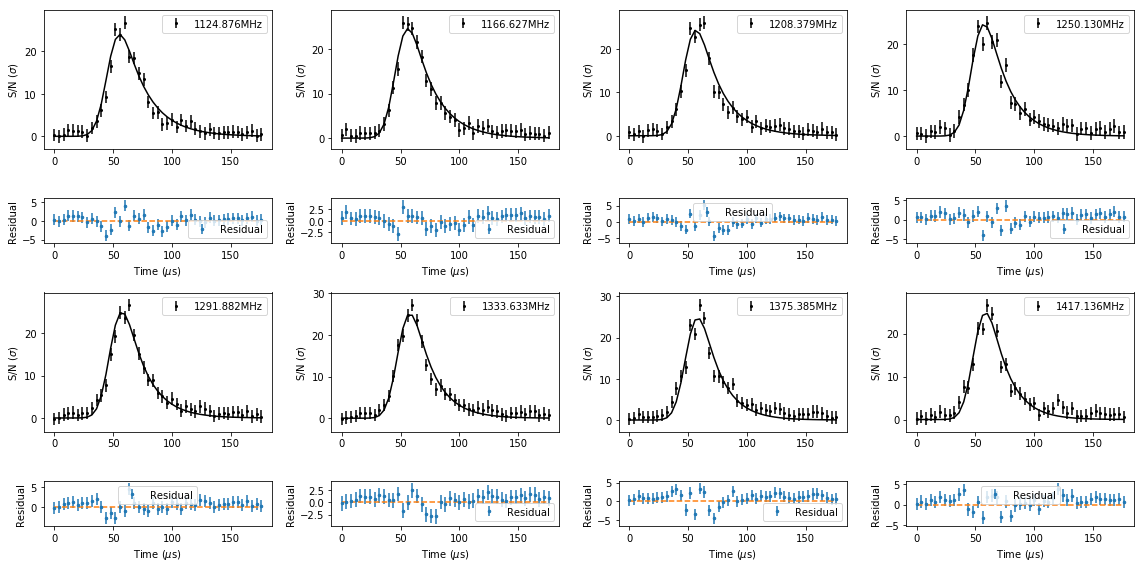

In [67]:
def plot_residual(time,y,ydata,sigma,figname="residuals"):

    gs=GridSpec(3*2,4)
    #gs.update(left=0.2, right=0.85, wspace=0.05,top=0.99,bottom=0.08)
    fig=plt.figure(figsize=(16,8))
    #olor_range=["red","blue","black","green"]
    for i in range(len(y)):
        #print(i,(i//4*3),(2+i//4*3),i%4)
        t1,t2=(i//4*3),(2+i//4*3)
        ax1=fig.add_subplot(gs[t1:t2,i%4])
        ax1.plot(time,y[i],color='black')
        ax1.set_ylabel("S/N ($\sigma$)")
        ax1.errorbar(time,ydata[i],yerr=sigma,fmt='o',ms=2,label="{0:.3f}".format(vi[i])+"MHz",color="black")
        plt.legend()
    #gs.update(wspace=0.5, hspace=1.0)
        ax2=fig.add_subplot(gs[t2,i%4],sharex=ax1)
        ax2.errorbar(time,(ydata[i]-y[i]),yerr=sigma,fmt='.',ms=5,label="Residual")
        #ax2.scatter(time,(ydata[i]-y[i])/sigma,s=5,label="residual in band"+str(i))

        ax2.plot(time,np.zeros(len(time)),"--")
        ax2.set_ylabel("Residual")
        ax2.set_xlabel("Time ($\\mu$s)")
        plt.tight_layout()
        plt.legend()

        #plt.savefig(figname+"band"+str(i)+".png",dpi=200)
    plt.savefig(figname+"residuals.png",dpi=200)
    plt.show()
#y=multipulse(time,t0,tau1,a1,a2,a3,a4,a5,a6,a7,a8,dmerr,sigi,alpha)
y=multipulse(time,t0,tau1,dmerr,sigi,alpha,a1,a2,a3,a4,a5,a6,a7,a8)
plot_residual(time,y,ydata,sigma,o)

### look into structure behind

(8, 4096)
6008.0 peak data


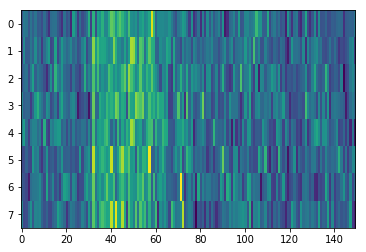

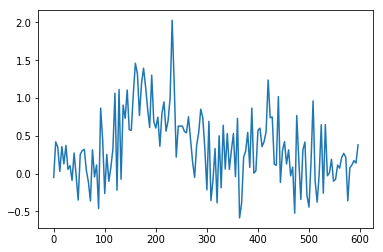

In [68]:
time,ydata,err=dataloader("frb_hightime.npy",chan_idx,head=-150,tail=300)
plt.imshow(ydata,aspect='auto')
plt.show()
#print(time,tsamp)
plt.plot(time,ydata[0])
plt.show()

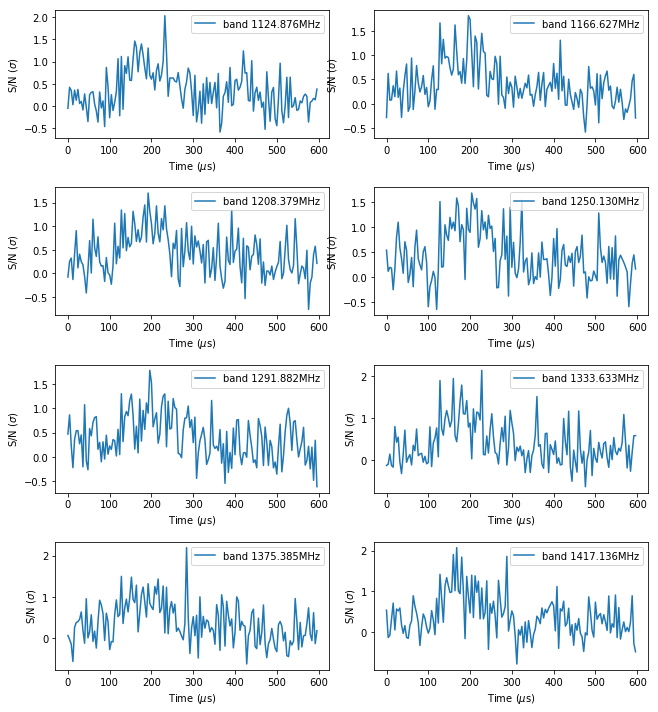

In [69]:
plt.figure(figsize=(9,10))
for i in range(8):
    plt.subplot(4,2,i+1)
    plt.plot(time,ydata[i],label="band "+"{0:.3f}".format(vi[i])+"MHz")
    #plt.plot(time,np.ones(len(time))*0.02,linestyle="--",label="rms from dynesty")
    plt.legend()
    plt.ylabel('S/N ($\sigma$)')
    plt.xlabel('Time ($\mu$s)')
plt.tight_layout()

#plt.savefig(o+"band_data.png",dpi=300)
plt.show()

In [70]:
amin=0.01
amax=5
taumax=200 ### us
simpoints=500

global priors1
print(10*tsamp,20*tsamp)
priors1 = bilby.core.prior.PriorDict()
priors1["t0"]=bilby.core.prior.Uniform(name='t0', minimum=20*tsamp,maximum=50*tsamp) ###
priors1["tau1"]=bilby.core.prior.LogUniform(name='$\\tau$', minimum=1, maximum=taumax)
priors1["a1"]=bilby.core.prior.Uniform(name='a1', minimum=amin, maximum=amax)
priors1["a2"]=bilby.core.prior.Uniform(name='a2', minimum=amin, maximum=amax)
priors1["a3"]=bilby.core.prior.Uniform(name='a3', minimum=amin, maximum=amax)
priors1["a4"]=bilby.core.prior.Uniform(name='a4', minimum=amin, maximum=amax)
priors1["a5"]=bilby.core.prior.Uniform(name='a5', minimum=amin, maximum=amax)
priors1["a6"]=bilby.core.prior.Uniform(name='a6', minimum=amin, maximum=amax)
priors1["a7"]=bilby.core.prior.Uniform(name='a7', minimum=amin, maximum=amax)
priors1["a8"]=bilby.core.prior.Uniform(name='a8', minimum=amin, maximum=amax)
priors1["dmerr"]=bilby.core.prior.Uniform(name='dmerr', minimum=-0.05,maximum=0.05)
priors1["sigi"]=bilby.core.prior.LogUniform(name='$\\sigma$', minimum=1, maximum=100)
priors1["alpha"]=bilby.core.prior.Uniform(name='alpha',minimum=1,maximum=10.0)
priors1["sigma"]=bilby.core.prior.Uniform(name='error',minimum=0.001,maximum=5)

40.0 80.0


In [71]:
likelihood = bilby.core.likelihood.GaussianLikelihood(x=time, y=ydata,func=multipulse, sigma=None)

In [72]:
result = bilby.sampler.run_sampler(likelihood=likelihood, priors=priors1,sampler='dynesty'
                                       ,npoints=simpoints,clean=True,dlogz=0.1,outdir='outdir',label=o+"_secondary")

23:03 bilby INFO    : Running for label 'frb_htr_test_secondary', output will be saved to 'outdir'
23:03 bilby INFO    : Search parameters:
23:03 bilby INFO    :   t0 = Uniform(minimum=80.0, maximum=200.0, name='t0', latex_label='t0', unit=None, boundary=None)
23:03 bilby INFO    :   tau1 = LogUniform(minimum=1, maximum=200, name='$\\tau$', latex_label='$\\tau$', unit=None, boundary=None)
23:03 bilby INFO    :   a1 = Uniform(minimum=0.01, maximum=5, name='a1', latex_label='a1', unit=None, boundary=None)
23:03 bilby INFO    :   a2 = Uniform(minimum=0.01, maximum=5, name='a2', latex_label='a2', unit=None, boundary=None)
23:03 bilby INFO    :   a3 = Uniform(minimum=0.01, maximum=5, name='a3', latex_label='a3', unit=None, boundary=None)
23:03 bilby INFO    :   a4 = Uniform(minimum=0.01, maximum=5, name='a4', latex_label='a4', unit=None, boundary=None)
23:03 bilby INFO    :   a5 = Uniform(minimum=0.01, maximum=5, name='a5', latex_label='a5', unit=None, boundary=None)
23:03 bilby INFO    :  

 11628| logz=-716.287 +/-  0.220 | dlogz: 43.772 >  0.100

23:29 bilby INFO    : Writing checkpoint file outdir/frb_htr_test_secondary_resume.pickle


 22101| logz=-675.027 +/-  0.269 | dlogz:  0.100 >  0.100

23:56 bilby INFO    : Writing checkpoint file outdir/frb_htr_test_secondary_resume.pickle


 22101| logz=-674.993 +/-  0.275 | dlogz:  0.000 >  0.100


23:56 bilby INFO    : Sampling time: 0:53:05.054665
23:56 bilby INFO    : Summary of results:
nsamples: 22601
log_noise_evidence:    nan
log_evidence: -674.993 +/-  0.275
log_bayes_factor:    nan +/-  0.275



In [73]:
triple=result.posterior
plotrange=[]
#histograms=[]
adjust=0.5
for i in triple.values.T:
    delta=i.max()-i.min()
    plotrange.append([i.min()-delta/100,i.max()+delta/100])
    #histograms.append(data[0])
plotrange[0][0]-=adjust
plotrange[0][1]+=adjust
plotrange[1][0]-=0.01
plotrange[1][1]+=0.01
#plotrange[2][0]-=adjust
#plotrange[2][1]+=adjust
values_toplot=triple.median()
result.plot_corner(parameters=['t0','tau1','a1','a2','a3','a4','a5','a6','a7','a8','dmerr','sigi','alpha','sigma'],
                   priors=priors1,filename=o+'_secondary_posterior.png',range=plotrange[:-2],
                  save=True)
plt.show()
print(values_toplot)
t0,tau1,a1,a2,a3,a4,a5,a6,a7,a8,dmerr,sigi,alpha,sigma=values_toplot[:-2]

t0                123.507052
tau1              145.482182
a1                  0.865676
a2                  0.946031
a3                  0.996300
a4                  1.033395
a5                  0.941056
a6                  1.040124
a7                  0.993622
a8                  1.064859
dmerr               0.000803
sigi               49.625150
alpha               1.644175
sigma               0.412082
log_likelihood   -638.380663
log_prior         -31.219768
dtype: float64


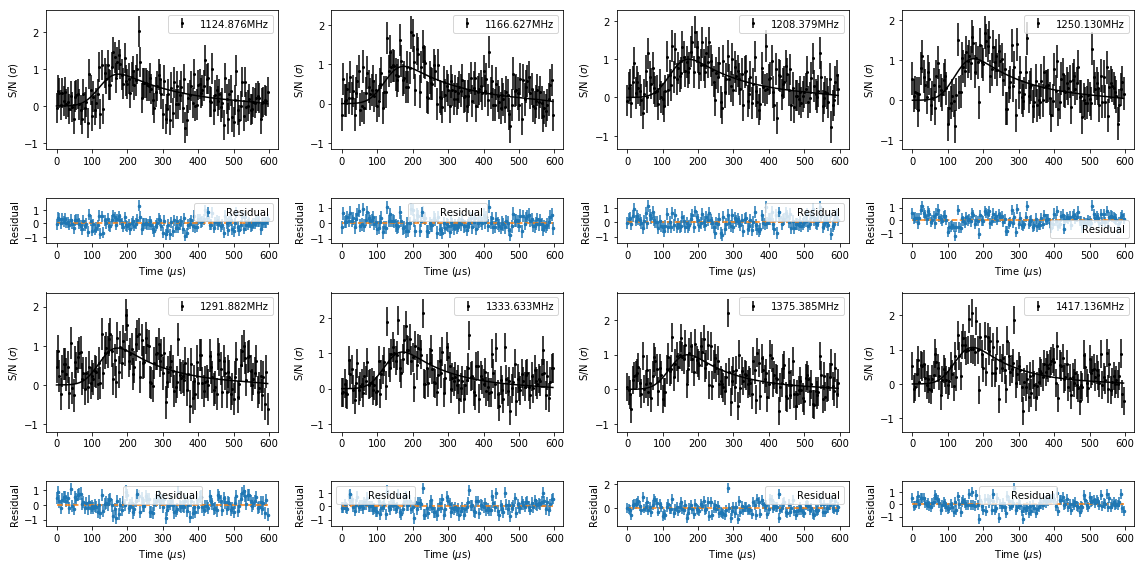

In [74]:
y=multipulse(time,t0,tau1,dmerr,sigi,alpha,a1,a2,a3,a4,a5,a6,a7,a8)
plot_residual(time,y,ydata,sigma,o+"_secondary")

(8, 4096)
6008.0 peak data


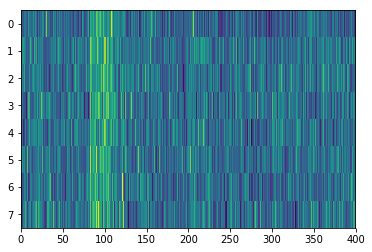

In [48]:
time,ydata,err=dataloader("frb_hightime.npy",chan_idx,head=15,tail=30)

def multigaus(t,t1,t2,dmerr,sigi,sigi2,a1,a2,a3,a4,a5,a6,a7,a8,b1,b2,b3,b4,b5,b6,b7,b8):
    amp_list=np.array([a1,a2,a3,a4,a5,a6,a7,a8])
    b_list=np.array([b1,b2,b3,b4,b5,b6,b7,b8])
    model=[]
    sigma=sigi
    sigma2=sigi2
    ti=tidm(dmerr,vi)*1000##ms--->us
    for vi,am,b in zip(freq,amp_list,b_list):
        #print (vi,am)
        pulse=gaus_func(width,t1,t,ti) ## create pulse
        flux=convolve(scat_corr,pulse,'same')
        flux/=np.max(flux) ### normalise
        gaus1=
        gaus2=
        model.append()
    return np.array(model)

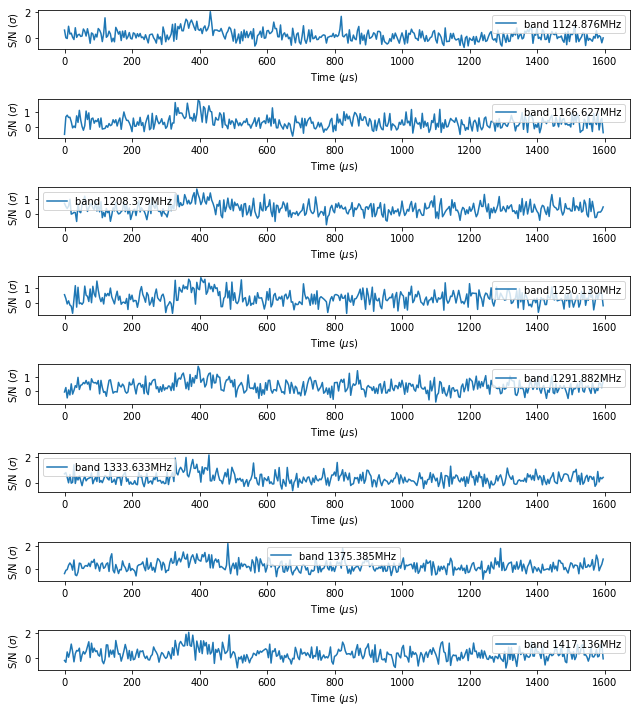